# TP4 : Travail final

## Imports et configuration

In [60]:
from collections import defaultdict
import os
import sys
import collections
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint

import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize

import yake
from collections import Counter
from wordcloud import WordCloud
from IPython.display import Image
from IPython.display import display

import spacy
from spacy.lang.fr.examples import sentences
nlp = spacy.load('fr_core_news_md')

from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from unidecode import unidecode

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\glmqu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
path = "../data/tp4_txt/"
files = sorted(os.listdir(path))

temp_path = '../data/tmp/'
if not os.path.exists(temp_path):
    os.mkdir(temp_path)

In [46]:
sw = stopwords.words("french")
sw += [
    # Coquilles OCR pas enlevées par fonction de nettoyage
    "brux", "belg", "cond", "intér","télép", "téléph", "parf", "aven", "épous", "lntér", "poli", "référ", "culs", "serv", "trav", "pers", "conf", "sach", "conn", "cuis", "chauf", "chauff", "journ", "cherc", "flam", "exlg", "ouvr", "prop", "meub", "domest", "chaus", "préf", "angl", "inst", "repr", "jard", "chamb", "terr", "franç", "élect", "conv", "rapp", "centr", "atel", "plac", "appartem", "coch", "tranq", "pled", "compr", "schaerb", "condlt", "adres", "aujourd", "couch", "compt", "pens", "exig", "conc", "comp", "situât", "merc", "gara", "couch", "charlerol",
    # Mots (quasiment) vides de sens
    "les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout", "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous", "celle", "entre", "encore", "toutes", "toute", "pendant", "moins", "dire", "voir", "cela", "non", "faut", "trois", "quatre", "cinq", "quart", "demi", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres", "van", "het", "autre", "jusqu", "très", "trop", "chez", "près", "toutes", "leurs", "avant", "suite", "rien", "quelques", "puis", "alors", "quand", "ceux", "elles", "déjà", "celui", "devant", "toujours", "outre", "tant", "mieux", "assez", "beaucoup", "plusieurs", "quelque", "quelques", "vers", "ensuite", "voici", "notamment", "chaque", "laquelle", "parmi",
    # Mots pas pertinents dans le contexte du journal
    "rossel", "agence", "nord", "midi", "royale", "ville", "avenue", "place", "boulevard", "chaussée", "saint", "octobre", "mardi", "août", "dimanche", "septembre", "lundi", "décembre", "janvier", "juin", "avril", "mercredi", "samedi", "novembre", "jeudi", "vendredi"]
sw = set(sw)

In [ ]:
##TODO à adapter pour créer un fichier unique

txts = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Stocker le contenu de ces fichiers dans une liste
content_list = []
for txt in txts:
    with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:
        content_list.append(f.read())

# Ecrire tout le contenu dans un fichier temporaire
with open(os.path.join(temp_path, f'tp4_all.txt'), 'w', encoding="utf-8") as f:
    f.write(' '.join(content_list))

In [ ]:
##TODO fonction de nettoyage à adapter

def clean_text(year, folder=None):
    if folder is None:
        input_path = f"{year}.txt"
        output_path = f"{year}_clean.txt"
    else:
        input_path = f"{folder}/{year}.txt"
        output_path = f"{folder}/{year}_clean.txt"
    output = open(output_path, "w", encoding='utf-8')
    with open(input_path, encoding='utf-8') as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.lower() for w in words if len(w) > 3 and w.isalpha() and w.lower() not in sw]
        kept_string = " ".join(kept)
        output.write(kept_string)
    return f'Output has been written in {output_path}!'

In [ ]:
#TODO sentence tokenizer

infile = "../data/all.txt"
outfile = "../data/sents.txt"

LIMIT = None

with open(outfile, 'w', encoding="utf-8") as output:
    with open(infile, encoding="utf-8", errors="backslashreplace") as f:
        content = f.readlines()
        content = content[:LIMIT] if LIMIT is not None else content
        n_lines = len(content)
        for i, line in enumerate(content):
            if i % 100 == 0:
                print(f'processing line {i}/{n_lines}')
            sentences = sent_tokenize(line)
            for sent in sentences:
                output.write(sent + "\n")
print("Done")

# Exploration du corpus

In [4]:
len(files)

3308

## Par année et par journal (TODO)

In [48]:
all_years = [str(year) for year in range(1921, 1966)]

count_decade = defaultdict(int)
count_year = defaultdict(int)
count_month = defaultdict(int)
count_newspapers = defaultdict(int)
covered_years = set()

for f in files:
    if "_" in f and f.endswith("txt"):
        elems = f.split("_")
        
        newspaper = elems[1]
        
        year = elems[2].split("-")[0]
        covered_years.add(year)
        decade = year[:3] + "0s"
        
        month = int(elems[2].split("-")[1])
        
        count_year[year] += 1
        count_decade[decade] += 1
        count_newspapers[newspaper] += 1
        count_month[month] += 1
    else:
        print(f"Anomalous file: {f}")

In [12]:
print(f"Il y a {count_newspapers['JB838']} exemplaires du Soir et {count_newspapers['JB1051']} exemplaires du Drapeau Rouge")

Il y a 2621 exemplaires du Soir et 687 exemplaires du Drapeau Rouge


In [10]:
missing_years = [y for y in all_years if y not in covered_years]
print(f"Années manquantes: {', '.join(missing_years)}")

Années manquantes: 


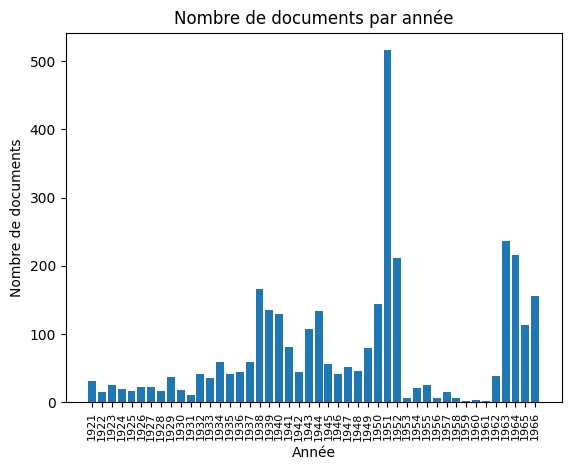

In [28]:
index = np.arange(len(count_year))
plt.bar(index, count_year.values())
plt.xlabel('Année')
plt.ylabel('Nombre de documents')
plt.xticks(index, sorted(count_year.keys()), fontsize=8, rotation=90)
plt.title('Nombre de documents par année')
plt.show()

## Vocabulaire du corpus

In [50]:
limit = 10**8

#TODO il faut créer un fichier temp avec tous les fichiers

with open(path + f, "r", encoding="utf-8") as f:
    text = f.read()[:limit]

In [51]:
# Tokenization
words = nltk.wordpunct_tokenize(text)
print(f"{len(words)} words found")
words[:10]

9001 words found


['LE',
 'som',
 'MARDI',
 '27',
 'DECEMBRE',
 '1966',
 'AU',
 'PALAIS',
 'DES',
 'BEAUX']

3208 words kept (2172 different word forms)
Hapaxes: ['som', 'decembre', 'von', 'accorde', 'soins', 'petites', 'sentiments', 'distractions', 'choisit', 'montrer', 'achats', 'cavernes', 'ali', 'baba', 'doivent', 'enrichir', 'patrimoine', 'délicate', 'certain', 'désarroi', 'règne', 'tient', 'crépuscule', 'génération', 'amateurs', 'flottement', 'indécis', 'wmï', 'hollandais', 'composition']


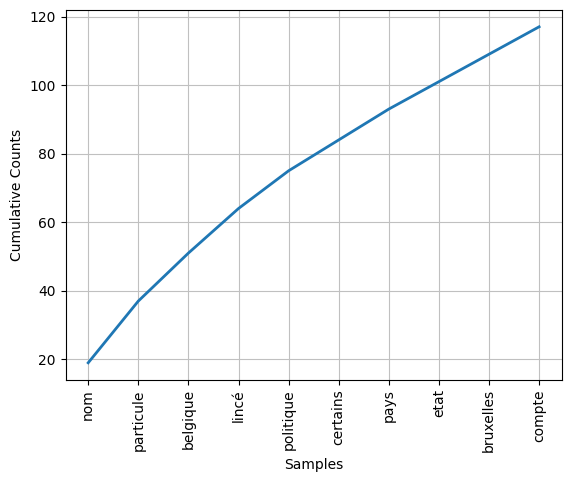

<AxesSubplot: xlabel='Samples', ylabel='Cumulative Counts'>

In [58]:
# Eliminer les stopwords et les termes non alphabétiques
kept = [w.lower() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
voc = set(kept)
print(f"{len(kept)} words kept ({len(voc)} different word forms)")

fdist = nltk.FreqDist(kept)
fdist.most_common(10)

print("Hapaxes:", fdist.hapaxes()[:30])

# Plot: les n mots les plus fréquents
n = 10
fdist.plot(n, cumulative=True)

# Extraction d'information

## Keywords

In [ ]:
# Instantier l'extracteur de mots clés en fr + les 50 premiers
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)
kw_extractor

# Récupérer le texte du temporaire de l'année étudiée, en mode lecture ('r'), en encodage utf-8
text = open(os.path.join(temp_path, f'tp4_all.txt'), 'r', encoding="utf-8").read()

# Extraire les mots clés de ce texte
keywords = kw_extractor.extract_keywords(text)
keywords

In [ ]:
# Ne garder que les bigrammes / trigrammes et plus
kept = []
for kw, score in keywords:
    words = kw.split()
    if len(words) == 2:
    # if len(words) == 3:
    # if len(words) > 3 :
        kept.append(kw)
kept

In [ ]:
# Faire la même opération sur tous les documents

for f in sorted(files)[:10]:
    text = open(os.path.join(path, f), 'r', encoding="utf-8").read()
    keywords = kw_extractor.extract_keywords(text)
    kept = []
    for kw, score in keywords:
        words = kw.split()
        if len(words) == 2:
            kept.append(kw)
    print(f"{f} mentions these keywords: {', '.join(kept)}...")

## Wordcloud

In [ ]:
# Appliquer la fonction et vérifier les résultats

clean_text(year, folder=temp_path)

with open(os.path.join(temp_path, f'{year}_clean.txt'), 'r', encoding="utf-8") as f:
    after = f.read()

# print(after[:500], "\n---")

# Calculer les mots les plus fréquents et afficher les résultats

frequencies = Counter(after.split())

print(frequencies.most_common(200))

In [ ]:
# Créer, stocker, afficher le nuage de mots

cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
cloud.to_file(os.path.join(temp_path, f"{year}.png"))
Image(filename=os.path.join(temp_path, f"{year}.png"))

## NER

In [ ]:
# Charger le texte
n=100000
text_NER = open(os.path.join(temp_path, f"{year}.txt"), 'r', encoding="utf-8").read()[:n]

# Traiter le texte

doc = nlp(text_NER)

# Compter les entités (personnes, lieux, organisations)

people = defaultdict(int)
places = defaultdict(int)
orga = defaultdict(int)

for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:
        people[ent.text] += 1
    elif ent.label_ == "LOC" and len(ent.text) > 3:
        places[ent.text] += 1
    elif ent.label_ == "ORG" and len(ent.text) > 3:
        orga[ent.text] += 1

# Trier

sorted_people = sorted(people.items(), key=lambda kv: kv[1], reverse=True)
sorted_places = sorted(places.items(), key=lambda kv: kv[1], reverse=True)
sorted_orga = sorted(orga.items(), key=lambda kv: kv[1], reverse=True)

In [ ]:
# Imprimer les 50 premières personnes

for person, freq in sorted_people[:50]:
    print(f"{person} apparait {freq} fois dans le corpus")

In [ ]:
# Imprimer les 50 premiers lieux

for place, freq in sorted_places[:50]:
    print(f"{place} apparait {freq} fois dans le corpus")

In [ ]:
# Imprimer les 50 premières organisations

for orga, freq in sorted_orga[:50]:
    print(f"{orga} apparait {freq} fois dans le corpus")

## Sentiment Analysis

In [ ]:
# Fonction

tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

def get_sentiment(input_text):
    blob = tb(input_text)
    polarity, subjectivity = blob.sentiment
    polarity_perc = f"{100*abs(polarity):.0f}"
    subjectivity_perc = f"{100*subjectivity:.0f}"
    if polarity > 0:
        polarity_str = f"{polarity_perc}% positive"
    elif polarity < 0:
        polarity_str = f"{polarity_perc}% negative"
    else:
        polarity_str = "neutral"
    if subjectivity > 0:
        subjectivity_str = f"{subjectivity}% subjective"
    else:
        subjectivity_str = "perfectly objective"
    print(f"This text is {polarity_str} and {subjectivity_str}.")

In [ ]:
# Exécuter la fonction sur des phrases choisies manuellement

get_sentiment("Trois d’entre elles purent être assez rapidement dégagées; quant au jeune Taelemans il fut tiré de sa situation critique sans connaissance.")

# Clustering

In [ ]:
# Création d'une fonction de pré-traitement

def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

# Instancier le modèle TF-IDF avec ses arguments

vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5, #ignorer les mots apparaissant dans plus de 50% des docs
    min_df=0.1, #ignorer les mots apparaissant dans moins de 10% des docs
    lowercase=True #tout mettre en minuscules
)

# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

tfidf_vectors = vectorizer.fit_transform(texts)

In [ ]:
# Imprimer les détails de la matrice

tfidf_vectors

## Faire les clusters

In [ ]:
# Elbow method pour déterminer le nbre de clusters optimal

distortions = []
K = range(1,15) #tested:1-10, 1-15, 1-30
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(tfidf_vectors)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# Nbre clusters

N_CLUSTERS = 4

# Instancier le modèle K-Means et ses arguments

km_model = KMeans(n_clusters=N_CLUSTERS)

# Appliquer le clustering à l'aide de la fonction fit_predict

clusters = km_model.fit_predict(tfidf_vectors)

clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [ ]:
# Afficher le résultat du clustering (un dictionnaire)

dict(clustering)

In [ ]:
# Réduire les vecteurs à 2 dimensions

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

# Générer le graphe

x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

## Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

## Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

## Explorer les clusters

In [ ]:
# Créer des fichiers tmp avec les textes des clusters

for key in clustering.keys():
    
    tmp_content_list = []

    for txt in clustering[key]:
        
        with open(os.path.join(txt_path, txt), 'r', encoding="utf-8") as f:
            tmp_content_list.append(f.read())
        
    with open(os.path.join(temp_path, f'{DECADE}s_cluster_{key}.txt'), 'w', encoding="utf-8") as f:
        f.write(' '.join(tmp_content_list))   

In [ ]:
# Regarder le nombre de documents par cluster

for key in clustering.keys():
    print(f"Nombre de documents dans le cluster {key} : {len(clustering[key])}")

In [ ]:
# Regarder la distribution des clusters selon les années

# Fonction basée autour d'une regex pour détecter l'année dans un nom de fichier
def get_year(filename):
    year = (re.search("([0-9]{4})", filename)).group()
    return year

# Création d'une liste de listes pour stocker les années pour chaque cluster
years_per_cluster = []
for key in clustering.keys():
    years_per_cluster.append([])

# Double boucle pour ajouter l'année pour chaque cluster
for key in clustering.keys():
    for i in clustering[key]:
        years_per_cluster[key].append(get_year(i))
    
    # testing
    # print(key, len(years_per_cluster[key]))

# testing
# print(years_per_cluster[0].count('1932'))

# Créer des graphes pour chaque cluster, en utilisant Counter pour compter le nbre de fichiers par années dans la liste de listes
for key in clustering.keys():
    tmp_counter = Counter(years_per_cluster[key])
    print(f"Cluster n° {key},", f"Nbre doc : {len(clustering[key])},", tmp_counter)

    plt.bar(tmp_counter.keys(), tmp_counter.values())
    plt.title(f"Cluster {key} : Nombre de documents par année")
    plt.show()

In [ ]:
# Regarder les mots-clés de chaque cluster

# Instantier l'extracteur de mots clés en fr + les 50 premiers
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)

# Récupérer le texte sauvegardé ci-dessus
text = open(os.path.join(temp_path, f'{DECADE}s_cluster_0.txt'), 'r', encoding="utf-8").read()

# Extraire les mots clés de ce texte
keywords = kw_extractor.extract_keywords(text)
print(f"Keywords, cluster n° 0 : {keywords}")

# Ne garder que les bigrammes / trigrammes
kept_bigrams = []
kept_trigrams = []
for kw, score in keywords:
    words = kw.split()
    if len(words) == 2: # si c'est un bigramme
        kept_bigrams.append(kw)
    elif len(words) == 3: # si c'est un trigramme
        kept_trigrams.append(kw)

print(f"Bigrammes récurrents, cluster n° 0 : {kept_bigrams}")
print(f"Trigrammes récurrents, cluster n° 0 : {kept_trigrams}")
print("")

In [ ]:
# Stopwords
sw = stopwords.words("french")
sw += [
    # Coquilles OCR pas enlevées par fonction de nettoyage
    "brux", "belg", "cond", "intér","télép", "téléph", "parf", "aven", "épous", "lntér", "poli", "référ", "culs", "serv", "trav", "pers", "conf", "sach", "conn", "cuis", "chauf", "chauff", "journ", "cherc", "flam", "exlg", "ouvr", "prop", "meub", "domest", "chaus", "préf", "angl", "inst", "repr", "jard", "chamb", "terr", "franç", "élect", "conv", "rapp", "centr", "atel", "plac", "appartem", "coch", "tranq", "pled", "compr", "schaerb", "condlt", "adres", "aujourd", "couch", "compt", "pens", "exig", "conc", "comp", "situât", "merc", "gara", "couch", "charlerol",
    # Mots (quasiment) vides de sens
    "les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout", "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous", "celle", "entre", "encore", "toutes", "toute", "pendant", "moins", "dire", "voir", "cela", "non", "faut", "trois", "quatre", "cinq", "quart", "demi", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres", "van", "het", "autre", "jusqu", "très", "trop", "chez", "près", "toutes", "leurs", "avant", "suite", "rien", "quelques", "puis", "alors", "quand", "ceux", "elles", "déjà", "celui", "devant", "toujours", "outre", "tant", "mieux", "assez", "beaucoup", "plusieurs", "quelque", "quelques", "vers", "ensuite", "voici", "notamment", "chaque", "laquelle", "parmi",
    # Mots pas pertinents dans le contexte du journal
    "rossel", "agence", "nord", "midi", "royale", "ville", "avenue", "place", "boulevard", "chaussée", "saint", "octobre", "mardi", "août", "dimanche", "septembre", "lundi", "décembre", "janvier", "juin", "avril", "mercredi", "samedi", "novembre", "jeudi", "vendredi"]
sw = set(sw)

# Fonction de nettoyage

def clean_text(key, folder=None):
    if folder is None:
        input_path = f"{DECADE}s_cluster_{key}.txt"
        output_path = f"{DECADE}s_cluster_{key}_clean.txt"
    else:
        input_path = f"{folder}{DECADE}s_cluster_{key}.txt"
        output_path = f"{folder}{DECADE}s_cluster_{key}_clean.txt"
    output = open(output_path, "w", encoding='utf-8')
    with open(input_path, encoding='utf-8') as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.lower() for w in words if len(w) > 3 and w.isalpha() and w.lower() not in sw]
        kept_string = " ".join(kept)
        output.write(kept_string)
    return f'Output has been written in {output_path}!'

# Word Embeddings

In [ ]:
# Création d'un objet qui streame les lignes d'un fichier pour économiser de la RAM

class MySentences(object):
    """Tokenize and Lemmatize sentences""" # Permet de tokenizer des "doubles" mots, par ex "premier" + "ministre" va être considéré comme un token "premier ministre"
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

infile = f"../data/sents.txt"
sentences = MySentences(infile)

In [ ]:
# Création de l'objet 'phrases' = "dictionnaire d'expressions multi-mots associées à un score", dont les clés correspondent aux termes du corpus

bigram_phrases = Phrases(sentences)

In [ ]:
# Conversion des objets 'phrases' en objet 'phraser' = version light du 'phrases' -> convertit certains unigrams en bigrams s'ils sont pertinents

bigram_phraser = Phraser(phrases_model=bigram_phrases)

# Sauvegarder l'objet Phraser des bigrammes

with open(f"{temp_path}bigrams.p", 'wb') as f:
    pickle.dump(bigram_phraser, f)

In [ ]:
# Ouvrir l'objet Phraser des bigrammes

bigram_phraser = pickle.load(open(f"{temp_path}bigrams.p", "rb"))

In [ ]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [ ]:
# Conversion en objet Phraser et sauvegarde du Phraser des trigrammes

trigram_phraser = Phraser(phrases_model=trigram_phrases)

with open(f"{temp_path}trigrams.p", 'wb') as f:
    pickle.dump(trigram_phraser, f)

In [ ]:
bigram_phraser = pickle.load(open(f"{temp_path}bigrams.p", "rb"))
trigram_phraser = pickle.load(open(f"{temp_path}trigrams.p", "rb"))

In [ ]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

# Imprimer une liste de n-grammes, qu'on répère car ils sont séparés par des _

print(corpus[:100])

In [ ]:
# Sauvegarder cette liste dans le dossier temporaire
# disabled cause not working

# with open(f"{temp_path}ngram_corpus.p", 'wb') as f:
#    pickle.dump(corpus, f)

In [ ]:
# Charger la liste des n-grams
# disabled cause not working

# corpus = pickle.load(open("ngrams_list.p", "rb"))

In [ ]:
%%time
model = Word2Vec( # default parameters
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=5, # La taille du "contexte" (avant/après le mot)
    min_count=5, # On ignore les mots qui n'apparaissent pas au moins 'min_count' fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en plusieurs threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs
)

# Sauver le modèle dans un fichier
outfile = f"{temp_path}newspapers_window5_mincount5.model"
model.save(outfile)

In [ ]:
# Charger les modèles en mémoire dans une liste

models = []

models.append(Word2Vec.load(f"{temp_path}newspapers_window5_mincount5.model"))
models.append(Word2Vec.load(f"{temp_path}newspapers_window3_mincount10.model"))
models.append(Word2Vec.load(f"{temp_path}newspapers_window10_mincount10.model"))
models.append(Word2Vec.load(f"{temp_path}newspapers_window20_mincount20.model"))

nb_models = len(models)

In [ ]:
# Fonction "similarity" : Calculer la similarité entre deux termes

first_term = ["journaliste", "chaud", "appartement", "socialiste", "chanter", "arbre", "enseigner"] # première liste des mots
second_term = ["presse", "froid", "louer", "chretien", "citroen", "branche", "theologiens"] # seconde liste de mots
nb_similarity_examples = len(first_term)

for i in range (nb_similarity_examples) : # pour chaque exemple
    for j in range (nb_models): # pour chaque modèle
        print(f"'{first_term[i]}' et '{second_term[i]}' (modèle {j}) : {models[j].wv.similarity(first_term[i], second_term[i])}") # imprimer la similarité entre les deux mots issus des deux listes
    print("")

In [ ]:
# Fonction "most_similar" : Chercher les mots les plus proches d'un terme donné

most_similar_word = ["peugeot", "enseigner", "rome", "bruxelles", "jardin", "habiter"] # liste de mots
nb_most_similar_examples = len(most_similar_word)

for i in range (nb_most_similar_examples) : # pour chaque exemple
    for j in range (nb_models): # pour chaque modèle
        print(f"Mots les plus semblables à '{most_similar_word[i]}' (modèle {j}) :", models[j].wv.most_similar(most_similar_word[i], topn=10)) # imprimer les mots les plus sembables au mot sélectionné
    print("")